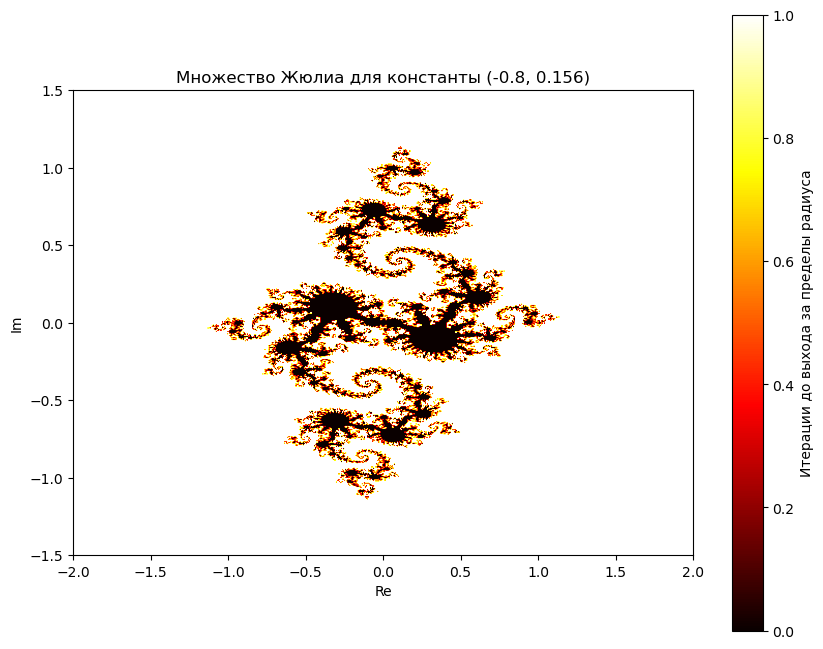

In [1]:
import pyopencl as cl
import numpy as np
import matplotlib.pyplot as plt

# Определение параметров для множества Жюлиа (множество Бернса-Шиппена)
width, height = 800, 600  # Разрешение изображения
xmin, xmax = -2.0, 2.0    # Границы комплексной плоскости по оси Re
ymin, ymax = -1.5, 1.5    # Границы комплексной плоскости по оси Im
max_iterations = 100      # Максимальное количество итераций
escape_radius = 2.0       # Радиус для условия выхода из цикла

context = cl.create_some_context()
queue = cl.CommandQueue(context)

kernel_code = """
__kernel void julia_set(__global float2 *output, const int width, const int height,
                        const float xmin, const float xmax, const float ymin, const float ymax,
                        const int max_iterations, const float escape_radius)
{
    int i = get_global_id(0);  // Индекс по горизонтали
    int j = get_global_id(1);  // Индекс по вертикали
    
    float x0 = xmin + i * (xmax - xmin) / (float)(width - 1);
    float y0 = ymin + j * (ymax - ymin) / (float)(height - 1);
    
    float2 z = (float2)(x0, y0);
    float2 c = (float2)(-0.8, 0.156);  // Константа для множества Жюлиа
    
    int iterations = 0;
    float magnitude_squared = 0.0;

    while (iterations < max_iterations && magnitude_squared < escape_radius * escape_radius)
    {
        float temp = z.x * z.x - z.y * z.y + c.x;
        z.y = 2.0 * z.x * z.y + c.y;
        z.x = temp;
        
        magnitude_squared = z.x * z.x + z.y * z.y;
        
        iterations++;
    }
    
    if (iterations == max_iterations)
        output[j * width + i] = (float2)(0.0f, 0.0f);  // Внутри множества
    else
        output[j * width + i] = (float2)(1.0f, 1.0f);  // Вне множества
}
"""

program = cl.Program(context, kernel_code).build()

output = np.zeros((height, width, 2)).astype(np.float32)
output_buffer = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, output.nbytes)

# Задание аргументов и запуск ядра
kernel = program.julia_set
kernel_args = (output_buffer, np.int32(width), np.int32(height),
               np.float32(xmin), np.float32(xmax), np.float32(ymin), np.float32(ymax),
               np.int32(max_iterations), np.float32(escape_radius))
kernel(queue, (width, height), None, *kernel_args)
queue.finish()

# Копирование результатов с устройства на хост
cl.enqueue_copy(queue, output, output_buffer).wait()

# Отображение изображения множества Жюлиа
plt.figure(figsize=(10, 8))
plt.imshow(output[:,:,0].T, cmap='hot', extent=[xmin, xmax, ymin, ymax])
plt.title("Множество Жюлиа для константы (-0.8, 0.156)")
plt.xlabel("Re")
plt.ylabel("Im")
plt.colorbar(label='Итерации до выхода за пределы радиуса')
plt.show()
